<a href="https://colab.research.google.com/github/wisrovi/RedesNeuronales/blob/master/07MAIR-WilliamSteveRodriguezVillamizar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliografia

In [0]:
#urlArchivos = "https://drive.google.com/drive/folders/1w2w5dAF269C646RBwwU33YLNUG4JRfh9?usp=sharing"

In [0]:
#!pip install tensorflow==2.0.0-alpha0

In [0]:
#https://github.com/jbagnato/machine-learning
#https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python#cnn
#https://www.datacamp.com/community/blog/keras-cheat-sheet
#https://www.pyimagesearch.com/2018/12/24/how-to-use-keras-fit-and-fit_generator-a-hands-on-tutorial/

# Iniciar Sistema

## Importar Librerias

In [1]:
#importo las librerias que se van a necesitar
import pickle
import matplotlib.pyplot as plt
import numpy as np

from keras import models
from keras import layers

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical #para que las salidas queden parametrizadas en binario

from sklearn.metrics import classification_report #para ver parametros 

from keras.applications.inception_v3 import decode_predictions #para ver varios items de prediccion

#para autoescalar la imagen al tamaño requerido por la red a reentrenar
from keras.applications.inception_v3 import preprocess_input

#Incrementar el número de ejemplos para evitar overfitting (junto con dropout)
#Generar datos a partir de los presentes, a través de transformaciones
from keras.preprocessing.image import ImageDataGenerator



# Para las librerias para la red neuronal
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

#callback para mejorar los entrenamientos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  

Using TensorFlow backend.


## Conexion con Google y Drive

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
###################################################################################################
BASE_FOLDER = '/content/gdrive/My Drive/Master IA/Redes Neuronales/'
###################################################################################################

In [0]:
#le indicamos al colaboratory que las importaciones de librerias propias se haran tambien desde el directorio base
import sys
sys.path.append(BASE_FOLDER)

## Importar Librerias propias

In [0]:
from ModeloExterno import ModeloExterno

## Funciones

In [0]:
#Algunas funciones utiles
def plot_image(img, title=""):
    #plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.title(title)
    #plt.axis('off')
    plt.show()

def convertLabelsToNumbers(y_train):
    # Transformando las labels de texto a valores numéricos
    y = np.unique(y_train)
    mapping = { key : value for key,value in zip(y,range(len(y)))}
    processed_y = np.array([mapping[i] for i in y_train])
    #print(len(mapping))
    return processed_y

def DividirDatos_Train_Test_Predic(x, y, porcentaje=0.33, randomDiv=52):
    # dividir los datos entre training, test y predic
    X_train, X_test, y_train, y_test = train_test_split(
        x_train_all, processed_y, 
        test_size=porcentaje, 
        random_state=randomDiv)

    X_test, X_predic, y_test, y_predic = train_test_split(
        X_test, y_test, 
        test_size=porcentaje, 
        random_state=randomDiv)
    
    #Hacemos el One-hot Encoding
    train_Y_one_hot = to_categorical(y_train)
    test_Y_one_hot = to_categorical(y_test)
    predic_Y_one_hot = to_categorical(y_predic)

    return (X_train, train_Y_one_hot), (X_test, test_Y_one_hot), (X_predic, predic_Y_one_hot)

def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['acc'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_pred(pred):
    plt.figure(figsize=(8, 2))
    classes = [c[1] for c in pred]
    probas = [c[2] for c in pred]
    y_pos = np.arange(len(classes))
    plt.barh(y_pos, probas, align='center')
    plt.yticks(y_pos, classes)
    plt.gca().invert_yaxis()
    plt.xlabel('Probability')
    plt.xlim(0, 1)

def DefineCallback():
    #EarlyStopping, para que el entrenamiento pare si ve que no mejora la función de coste tras determinados epochs
    early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, min_delta=1e-4)  

    #ReduceLROnPlateau, que si el entrenamiento no mejora tras unos epochs específicos, reduce el valor de learning rate del modelo
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)  
    callbacks_list = [early_stop, reduce_lr]  
    return callbacks_list

## Importar Dataseet y clases

In [8]:
#Cargo los archivos de clases y las imagenes
with open(BASE_FOLDER+"pickle_all_images_df-002.pickle", "rb") as input_file:
    x_train_all = pickle.load(input_file)
with open(BASE_FOLDER+"pickle_all_classes.pickle", "rb") as input_file:
    y_train_all = pickle.load(input_file)

number_of_classes = len(y_train_all)

print("Entradas: ",x_train_all.shape)
print("Salidas: ", number_of_classes)

Entradas:  (9145, 128, 128, 3)
Salidas:  9145


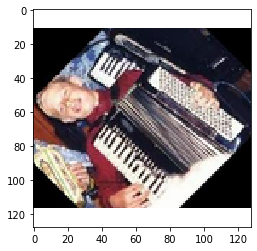

In [9]:
#show image
plot_image(x_train_all[15])

In [10]:
processed_y = convertLabelsToNumbers(y_train_all)
salidasCategoricas = to_categorical(processed_y)

print(len(salidasCategoricas[1]))

classesImageGenerator = np.unique(salidasCategoricas)
nClassesImageGenerator = len(salidasCategoricas[1])
print(nClassesImageGenerator)

102
102


# Aumentar el set de datos con DataGenerator

### Creando el modelo generador de datos

In [15]:
X_train_generator, X_test_generator, y_train_generator, y_test_generator = train_test_split(
        x_train_all, salidasCategoricas, 
        test_size=0.33, 
        random_state=52)

print(X_train_generator.shape, y_train_generator.shape)
print(X_test_generator.shape, y_test_generator.shape)

(6127, 128, 128, 3) (6127, 102)
(3018, 128, 128, 3) (3018, 102)


In [0]:
modelImageGenerator = ModeloExterno(nombreModelo="wisrovi-imageGenerator", rutaBase=BASE_FOLDER)

In [41]:
#Aumentamos el dataset para tener mas datos que procesar
datagen = ImageDataGenerator(
    rotation_range=25, # grados de rotacion aleatoria
    width_shift_range=0.2, # fraccion del total (1) para mover la imagen
    height_shift_range=0.2, # fraccion del total (1) para mover la imagen
    shear_range=0.1, # deslizamiento
    zoom_range=0.1, # rango de zoom
    horizontal_flip=True, # girar las imagenes horizontalmente (eje vertical)
    fill_mode='nearest', # como rellenar posibles nuevos pixeles
    channel_shift_range=0.2 # cambios aleatorios en los canales de la imagen
)

convnet_augmentation = models.Sequential()
convnet_augmentation.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu', padding='same'))
convnet_augmentation.add(Conv2D(32,(3,3),activation='relu'))
convnet_augmentation.add(MaxPooling2D((2, 2),padding='same'))
convnet_augmentation.add(Dropout(0.5))
convnet_augmentation.add(Conv2D(32,(3,3),activation='relu'))
convnet_augmentation.add(MaxPooling2D((2,2)))
convnet_augmentation.add(Flatten())
convnet_augmentation.add(Dropout(0.25))
convnet_augmentation.add(Dense(32,activation='relu'))
convnet_augmentation.add(Dropout(0.5))
convnet_augmentation.add(Dense(nClassesImageGenerator,activation='softmax'))

convnet_augmentation.compile(optimizer='rmsprop',
               loss='categorical_crossentropy', #para mas de dos clases de clasificación
               metrics=['accuracy'])

convnet_augmentation.summary()

modelImageGenerator.GuardarModelo(convnet_augmentation)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 61, 61, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 28800)            

True

### Preparando y entrenando el modelo Generador de datos

2857


Entrenamiento 1
Epoch 1/10
2857/2857 [==============================] - 217s 76ms/step - loss: 3.6928 - acc: 0.2112 - val_loss: 3.4603 - val_acc: 0.2886
Epoch 2/10
2857/2857 [==============================] - 210s 73ms/step - loss: 3.5184 - acc: 0.2410 - val_loss: 3.5258 - val_acc: 0.2323
Epoch 3/10
2857/2857 [==============================] - 207s 72ms/step - loss: 3.4860 - acc: 0.2491 - val_loss: 3.5823 - val_acc: 0.2064
Epoch 4/10
2857/2857 [==============================] - 207s 73ms/step - loss: 3.4854 - acc: 0.2494 - val_loss: 3.6682 - val_acc: 0.1885
Epoch 5/10
2857/2857 [==============================] - 207s 73ms/step - loss: 3.5061 - acc: 0.2476 - val_loss: 3.8867 - val_acc: 0.1398
Epoch 6/10
2857/2857 [==============================] - 210s 73ms/step - loss: 3.5931 - acc: 0.2362 - val_loss: 3.9152 - val_acc: 0.1395
Epoch 7/10
2857/2857 [==============================] - 211s 74ms/step - loss: 3.6939 - acc: 0.2280 - val_loss: 3.6116 - val_acc: 0.2127
Epoch 8/10
2857/28

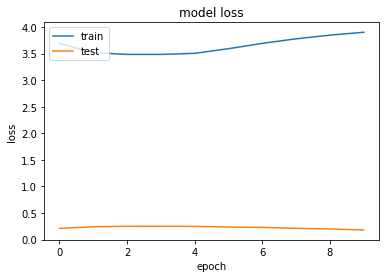

3018/3018 [==============================] - 1s 349us/step
Test loss: 3.779005428589757
Test accuracy: 0.2229953611762102
Pesos Guardados!
***************



Entrenamiento 2
Epoch 1/10
2857/2857 [==============================] - 209s 73ms/step - loss: 3.8775 - acc: 0.1790 - val_loss: 3.7397 - val_acc: 0.2021
Epoch 2/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.8395 - acc: 0.1880 - val_loss: 3.7440 - val_acc: 0.2111
Epoch 3/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.8398 - acc: 0.1898 - val_loss: 3.6295 - val_acc: 0.2826
Epoch 4/10
2857/2857 [==============================] - 213s 75ms/step - loss: 3.8442 - acc: 0.1862 - val_loss: 3.6603 - val_acc: 0.2684
Epoch 5/10
2857/2857 [==============================] - 212s 74ms/step - loss: 3.8401 - acc: 0.1835 - val_loss: 4.2430 - val_acc: 0.0524
Epoch 6/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.8450 - acc: 0.1875 - val_loss: 3.8596 - val_acc: 0.2011
Epoc

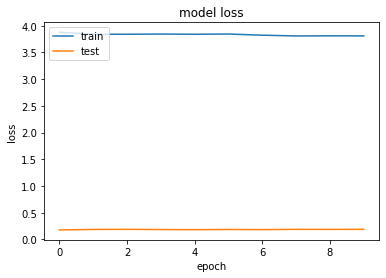

3018/3018 [==============================] - 1s 344us/step
Test loss: 4.255956389716005
Test accuracy: 0.07289595759768135
***************



Entrenamiento 3
Epoch 1/10
2857/2857 [==============================] - 209s 73ms/step - loss: 3.8093 - acc: 0.1878 - val_loss: 3.9607 - val_acc: 0.1193
Epoch 2/10
2857/2857 [==============================] - 209s 73ms/step - loss: 3.8016 - acc: 0.1908 - val_loss: 3.9837 - val_acc: 0.1995
Epoch 3/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7937 - acc: 0.1899 - val_loss: 3.8828 - val_acc: 0.1690
Epoch 4/10
2857/2857 [==============================] - 209s 73ms/step - loss: 3.7879 - acc: 0.1920 - val_loss: 4.1694 - val_acc: 0.0636
Epoch 5/10
2857/2857 [==============================] - 206s 72ms/step - loss: 3.7862 - acc: 0.1927 - val_loss: 3.7950 - val_acc: 0.2114
Epoch 6/10
2857/2857 [==============================] - 207s 72ms/step - loss: 3.7873 - acc: 0.1934 - val_loss: 4.1373 - val_acc: 0.0742
Epoch 7/10
2857/2857

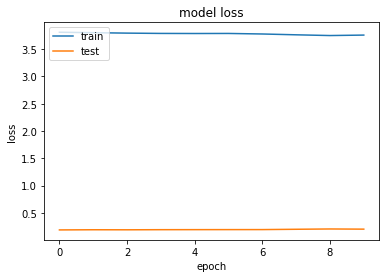

3018/3018 [==============================] - 1s 350us/step
Test loss: 3.675317095319825
Test accuracy: 0.2604373757850263
Pesos Guardados!
***************



Entrenamiento 4
Epoch 1/10
2857/2857 [==============================] - 203s 71ms/step - loss: 3.7930 - acc: 0.2038 - val_loss: 3.9894 - val_acc: 0.1146
Epoch 2/10
2857/2857 [==============================] - 202s 71ms/step - loss: 4.0229 - acc: 0.2014 - val_loss: 4.5235 - val_acc: 0.1266
Epoch 3/10
2857/2857 [==============================] - 202s 71ms/step - loss: 3.7658 - acc: 0.2028 - val_loss: 3.7076 - val_acc: 0.2197
Epoch 4/10
2857/2857 [==============================] - 204s 71ms/step - loss: 3.7611 - acc: 0.2031 - val_loss: 3.8237 - val_acc: 0.1958
Epoch 5/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.7663 - acc: 0.1998 - val_loss: 4.1517 - val_acc: 0.0921
Epoch 6/10
2857/2857 [==============================] - 210s 74ms/step - loss: 3.7622 - acc: 0.2022 - val_loss: 3.6033 - val_acc: 0.2502
Epoc

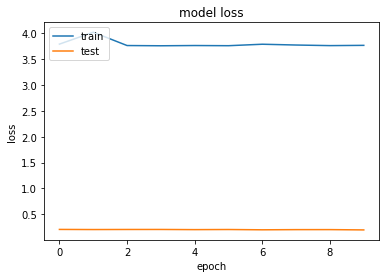

3018/3018 [==============================] - 1s 346us/step
Test loss: 3.980966988267134
Test accuracy: 0.12259774685715744
***************



Entrenamiento 5
Epoch 1/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7832 - acc: 0.1970 - val_loss: 4.4476 - val_acc: 0.0583
Epoch 2/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.7750 - acc: 0.1938 - val_loss: 3.9131 - val_acc: 0.1362
Epoch 3/10
2857/2857 [==============================] - 212s 74ms/step - loss: 3.7897 - acc: 0.1930 - val_loss: 4.3358 - val_acc: 0.1339
Epoch 4/10
2857/2857 [==============================] - 209s 73ms/step - loss: 3.7742 - acc: 0.1950 - val_loss: 4.1028 - val_acc: 0.1236
Epoch 5/10
2857/2857 [==============================] - 209s 73ms/step - loss: 3.7624 - acc: 0.1972 - val_loss: 4.1371 - val_acc: 0.1365
Epoch 6/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7579 - acc: 0.1992 - val_loss: 3.9116 - val_acc: 0.1624
Epoch 7/10
2857/2857

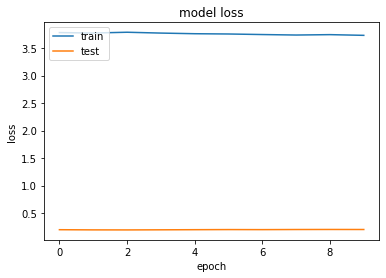

3018/3018 [==============================] - 1s 322us/step
Test loss: 3.9536834995504875
Test accuracy: 0.13883366468846994
***************



Entrenamiento 6
Epoch 1/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7327 - acc: 0.2024 - val_loss: 3.9282 - val_acc: 0.1398
Epoch 2/10
2857/2857 [==============================] - 206s 72ms/step - loss: 3.7294 - acc: 0.2035 - val_loss: 3.9361 - val_acc: 0.1501
Epoch 3/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7245 - acc: 0.2036 - val_loss: 4.0646 - val_acc: 0.1233
Epoch 4/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7343 - acc: 0.2037 - val_loss: 3.9268 - val_acc: 0.1524
Epoch 5/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7497 - acc: 0.2003 - val_loss: 3.8542 - val_acc: 0.1650
Epoch 6/10
2857/2857 [==============================] - 206s 72ms/step - loss: 3.7339 - acc: 0.2030 - val_loss: 3.8066 - val_acc: 0.1865
Epoch 7/10
2857/285

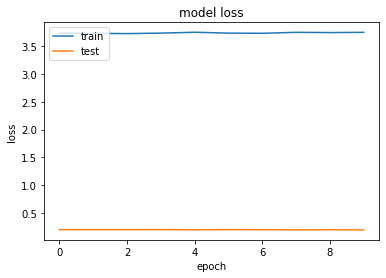

3018/3018 [==============================] - 1s 353us/step
Test loss: 3.8862970061773017
Test accuracy: 0.14844267730921448
***************



Entrenamiento 7
Epoch 1/10
2857/2857 [==============================] - 204s 71ms/step - loss: 3.7500 - acc: 0.1979 - val_loss: 3.8868 - val_acc: 0.1600
Epoch 2/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7467 - acc: 0.1975 - val_loss: 3.7293 - val_acc: 0.1865
Epoch 3/10
2857/2857 [==============================] - 203s 71ms/step - loss: 3.7522 - acc: 0.1979 - val_loss: 4.2290 - val_acc: 0.1342
Epoch 4/10
2857/2857 [==============================] - 201s 70ms/step - loss: 3.7556 - acc: 0.1985 - val_loss: 4.0326 - val_acc: 0.1491
Epoch 5/10
2857/2857 [==============================] - 201s 70ms/step - loss: 3.7681 - acc: 0.1962 - val_loss: 4.0361 - val_acc: 0.1713
Epoch 6/10
2857/2857 [==============================] - 201s 70ms/step - loss: 3.7534 - acc: 0.1977 - val_loss: 4.8459 - val_acc: 0.1395
Epoch 7/10
2857/285

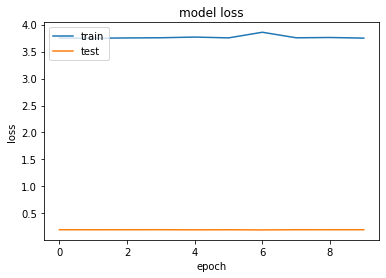

3018/3018 [==============================] - 1s 346us/step
Test loss: 3.922247505567183
Test accuracy: 0.1414844267776346
***************



Entrenamiento 8
Epoch 1/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7416 - acc: 0.1997 - val_loss: 4.1223 - val_acc: 0.1392
Epoch 2/10
2857/2857 [==============================] - 204s 72ms/step - loss: 3.7552 - acc: 0.1966 - val_loss: 4.0204 - val_acc: 0.1494
Epoch 3/10
2857/2857 [==============================] - 203s 71ms/step - loss: 3.7456 - acc: 0.1971 - val_loss: 4.1680 - val_acc: 0.0636
Epoch 4/10
2857/2857 [==============================] - 204s 71ms/step - loss: 3.7611 - acc: 0.1973 - val_loss: 3.8605 - val_acc: 0.1531
Epoch 5/10
2857/2857 [==============================] - 203s 71ms/step - loss: 3.7556 - acc: 0.1980 - val_loss: 4.1446 - val_acc: 0.1455
Epoch 6/10
2857/2857 [==============================] - 202s 71ms/step - loss: 3.7561 - acc: 0.1973 - val_loss: 4.2790 - val_acc: 0.0616
Epoch 7/10
2857/2857 

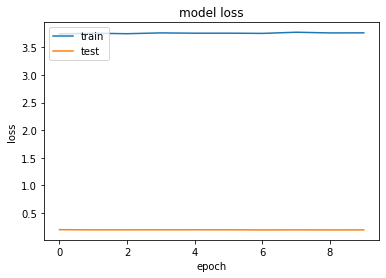

3018/3018 [==============================] - 1s 326us/step
Test loss: 4.997644195973755
Test accuracy: 0.07819748181551003
***************



Entrenamiento 9
Epoch 1/10
2857/2857 [==============================] - 205s 72ms/step - loss: 3.7679 - acc: 0.1924 - val_loss: 3.9576 - val_acc: 0.1713
Epoch 2/10
2857/2857 [==============================] - 202s 71ms/step - loss: 3.7593 - acc: 0.1960 - val_loss: 3.8506 - val_acc: 0.1551
Epoch 3/10
2857/2857 [==============================] - 203s 71ms/step - loss: 3.7656 - acc: 0.1933 - val_loss: 3.8319 - val_acc: 0.1531
Epoch 4/10
2857/2857 [==============================] - 201s 70ms/step - loss: 3.7684 - acc: 0.1900 - val_loss: 4.5643 - val_acc: 0.0563
Epoch 5/10
2857/2857 [==============================] - 199s 70ms/step - loss: 3.7689 - acc: 0.1934 - val_loss: 4.9353 - val_acc: 0.0616
Epoch 6/10
2857/2857 [==============================] - 199s 70ms/step - loss: 3.7800 - acc: 0.1929 - val_loss: 3.9405 - val_acc: 0.1693
Epoch 7/10
2857/2857

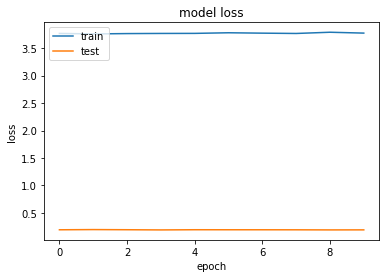

3018/3018 [==============================] - 1s 408us/step
Test loss: 3.842180002754773
Test accuracy: 0.16070245199443647
***************



Entrenamiento 10
Epoch 1/10
2857/2857 [==============================] - 210s 73ms/step - loss: 3.7834 - acc: 0.1897 - val_loss: 3.7108 - val_acc: 0.2253
Epoch 2/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.7734 - acc: 0.1906 - val_loss: 4.0272 - val_acc: 0.1643
Epoch 3/10
2857/2857 [==============================] - 209s 73ms/step - loss: 3.7785 - acc: 0.1927 - val_loss: 4.8705 - val_acc: 0.1435
Epoch 4/10
2857/2857 [==============================] - 207s 73ms/step - loss: 3.7729 - acc: 0.1909 - val_loss: 4.6796 - val_acc: 0.1418
Epoch 5/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.7686 - acc: 0.1906 - val_loss: 5.4296 - val_acc: 0.1504
Epoch 6/10
2857/2857 [==============================] - 209s 73ms/step - loss: 3.7749 - acc: 0.1909 - val_loss: 4.0628 - val_acc: 0.1455
Epoch 7/10
2857/285

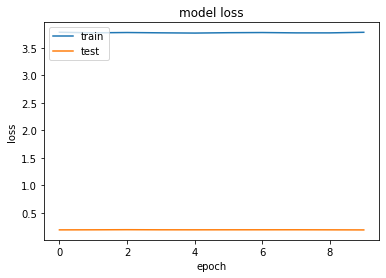

3018/3018 [==============================] - 1s 412us/step
Test loss: 3.846003374885928
Test accuracy: 0.15374420146779402
***************



Entrenamiento 11
Epoch 1/10
2857/2857 [==============================] - 212s 74ms/step - loss: 3.7836 - acc: 0.1888 - val_loss: 3.9592 - val_acc: 0.1415
Epoch 2/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.7775 - acc: 0.1922 - val_loss: 4.1261 - val_acc: 0.0596
Epoch 3/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.7734 - acc: 0.1890 - val_loss: 3.9777 - val_acc: 0.1322
Epoch 4/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.7819 - acc: 0.1901 - val_loss: 3.8629 - val_acc: 0.1624
Epoch 5/10
2857/2857 [==============================] - 207s 73ms/step - loss: 3.7872 - acc: 0.1870 - val_loss: 4.2260 - val_acc: 0.0921
Epoch 6/10
2857/2857 [==============================] - 207s 73ms/step - loss: 3.7842 - acc: 0.1886 - val_loss: 3.8987 - val_acc: 0.1600
Epoch 7/10
2857/285

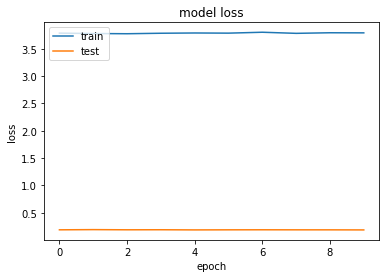

3018/3018 [==============================] - 1s 416us/step
Test loss: 4.048517630383066
Test accuracy: 0.12326043741524496
***************



Entrenamiento 12
Epoch 1/10
2857/2857 [==============================] - 214s 75ms/step - loss: 3.7970 - acc: 0.1874 - val_loss: 4.9903 - val_acc: 0.0885
Epoch 2/10
2857/2857 [==============================] - 210s 74ms/step - loss: 3.7919 - acc: 0.1861 - val_loss: 3.9844 - val_acc: 0.1687
Epoch 3/10
2857/2857 [==============================] - 208s 73ms/step - loss: 3.7860 - acc: 0.1887 - val_loss: 4.1121 - val_acc: 0.1484
Epoch 4/10
2857/2857 [==============================] - 211s 74ms/step - loss: 3.7875 - acc: 0.1892 - val_loss: 4.1826 - val_acc: 0.0868
Epoch 5/10
2857/2857 [==============================] - 209s 73ms/step - loss: 3.7981 - acc: 0.1813 - val_loss: 3.7027 - val_acc: 0.1806
Epoch 6/10
2857/2857 [==============================] - 211s 74ms/step - loss: 3.7932 - acc: 0.1833 - val_loss: 3.9374 - val_acc: 0.1329
Epoch 7/10
2857/285

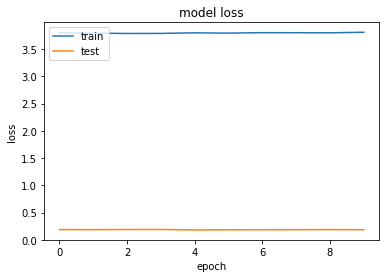

3018/3018 [==============================] - 1s 385us/step
Test loss: 4.684779443987321
Test accuracy: 0.10702451958886988
***************



Entrenamiento 13
Epoch 1/10
2857/2857 [==============================] - 207s 72ms/step - loss: 3.8074 - acc: 0.1818 - val_loss: 4.4072 - val_acc: 0.1488
Epoch 2/10
2182/2857 [=====================>........] - ETA: 47s - loss: 3.7925 - acc: 0.1880

In [0]:
# es necesario especificar el numero de steps cuando se usa un generator (para saber cuando dejar de generar datos en una epoca)
batch_size = 32
num_samples = x_train_all.shape[0] * 10 # multiplicar por 10 el numero de ejemplos
pasos_por_epoca = num_samples//batch_size
iterator_datagen_train = datagen.flow( X_train_generator, y_train_generator,  batch_size=batch_size  )
print(pasos_por_epoca)

numeroEntrenamientos = 30
numeroEpocas = 10
oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history_augmentation = convnet_augmentation.fit_generator(
        iterator_datagen_train,
        epochs=numeroEpocas,
        validation_data=(
            X_test_generator, y_test_generator
        ),
        workers=4,
        steps_per_epoch=pasos_por_epoca,
        callbacks=DefineCallback())
        
    plot_history(history_augmentation)
    


    test_eval = convnet_augmentation.evaluate(X_test_generator, y_test_generator, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modelImageGenerator.GuardarPesosModelo()
        oldModel = convnet_augmentation
    else:
        convnet_augmentation = oldModel

    print("***************")    
    print()

In [0]:
#falta terminar, mirar como con que modelo entrenado puedo generar las imagenes
convnet_augmentation.eva

In [0]:
#falta terminar, mirar como puedo generar las imagenes sin tener que guardarlas en directorio 
#sino guardarlas en los archivos en las fuentes x_train_all y y_train_all
datagen.flow

In [0]:
#falta terminar, buscar que en lugar de guardar en un archivo, guarde el vector
imageGen = datagen.flow(X_test_generator[0], batch_size=1, save_to_dir=args["output"],
	save_prefix="image", save_format="jpg")

for image in imageGen:
	# increment our counter
	total += 1
 
	# if we have reached the specified number of examples, break
	# from the loop
	if total == args["total"]:
		break

# Repartiendo los datos entre Train, test, eval y predic

In [0]:
imagen = 250
#print(processed_y[imagen], y_train_all[imagen])

In [12]:
classes = np.unique(processed_y)
nClasses = len(classes)
print("Numero de clases diferenes:", nClasses)
print()

(X_train, y_train), (X_test, y_test), (X_predic, y_predic) = DividirDatos_Train_Test_Predic(x_train_all, processed_y)

print("Training (66.98%)") 
print("X_train", X_train.shape)
print("y_train", y_train.shape)
print() 
print("Test (22.1%)") 
print("X_test", X_test.shape)
print("y_test", y_test.shape)
print()
print("Predict (10.89%)") 
print("X_predic", X_predic.shape)
print("y_predic", y_predic.shape)

print()
if y_predic.shape[1] == y_test.shape[1] and y_test.shape[1] == y_train.shape[1]:
    print("Distribución correcta")
else:
    print("Fallo en la distribución")

Numero de clases diferenes: 102

Training (66.98%)
X_train (6127, 128, 128, 3)
y_train (6127, 102)

Test (22.1%)
X_test (2022, 128, 128, 3)
y_test (2022, 102)

Predict (10.89%)
X_predic (996, 128, 128, 3)
y_predic (996, 102)

Distribución correcta


In [13]:
#Creamos el Set de Entrenamiento y Validación
#divido los datos de entrenamiento en dos, un 80% para el entrenamiento y otro 20% para validacion
train_X,valid_X,train_label,valid_label = train_test_split(
    X_train, y_train, 
    test_size=0.1, random_state=43)

print("training")
print(train_X.shape)
print(train_label.shape)
print()
print("Valid")
print(valid_X.shape)
print(valid_label.shape)

training
(5514, 128, 128, 3)
(5514, 102)

Valid
(613, 128, 128, 3)
(613, 102)


# Nueva Red Neuronal

## Red Neuronal

In [0]:
modelExtern = ModeloExterno(nombreModelo="wisrovi-nuevoModelo", rutaBase=BASE_FOLDER)

In [15]:
print("********** Modelo *********")

new_model = Sequential()
new_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )
new_model.add(Dense(128, activation='relu'))
new_model.add(MaxPooling2D((2, 2),padding='same'))
new_model.add(Dropout(0.5))

new_model.add(Dense(120, activation='relu'))
new_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(64, activation='relu'))
new_model.add(Flatten()) #para aplanar todas las capas
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(87, activation='relu'))
new_model.add(Dropout(0.5)) #apagar un 50% de manera aleatoria para reducir la cantidad de parametros
new_model.add(Dense(nClasses, activation='softmax')) #Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion

#new_model.summary()

new_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modelExtern.GuardarModelo(new_model)

********** Modelo *********





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Modelo guardado!


True

## Entrenar el modelo



Entrenamiento 1
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 5514 samples, validate on 613 samples
Epoch 1/10





5514/5514 [==============================] - 17s 3ms/step - loss: 4.2469 - acc: 0.1095 - val_loss: 3.5843 - val_acc: 0.2561
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 3.5145 - acc: 0.2695 - val_loss: 3.1922 - val_acc: 0.3377
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 3.2200 - acc: 0.3188 - val_loss: 3.0968 - val_acc: 0.3524
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 3.0473 - acc: 0.3448 - val_loss: 2.9667 - val_acc: 0.3638
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 2.9047 - acc: 0.3618 - val_loss: 2.8362 - val_acc: 0.3703
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 2.7726 - acc: 0.3754 - val_loss: 2.8238 - val_acc: 0.3834
Epoch 7/10
5514/5514 [======

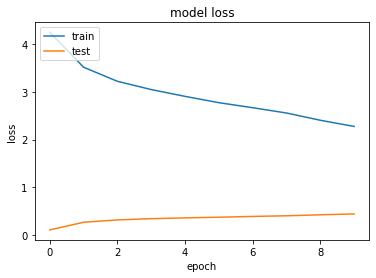

2022/2022 [==============================] - 1s 704us/step
Test loss: 2.6455393221918366
Test accuracy: 0.41196834817012856
Pesos Guardados!
***************



Entrenamiento 2
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 2.0802 - acc: 0.4764 - val_loss: 2.7749 - val_acc: 0.4127
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.9887 - acc: 0.4926 - val_loss: 2.7088 - val_acc: 0.4078
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.8348 - acc: 0.5272 - val_loss: 2.7750 - val_acc: 0.4111
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.7010 - acc: 0.5466 - val_loss: 2.8323 - val_acc: 0.3915
Epoch 5/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.5515 - acc: 0.5753 - val_loss: 2.9929 - val_acc: 0.4176
Epoch 6/10
5514/5514 [==============================] - 9s 2ms/step - loss: 1.4051 - acc: 0.6181 - val_loss

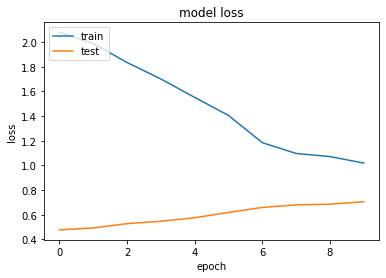

2022/2022 [==============================] - 1s 676us/step
Test loss: 3.605577761294462
Test accuracy: 0.4277942631353139
Pesos Guardados!
***************



Entrenamiento 3
Train on 5514 samples, validate on 613 samples
Epoch 1/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9758 - acc: 0.7156 - val_loss: 3.5869 - val_acc: 0.4241
Epoch 2/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9856 - acc: 0.7124 - val_loss: 3.5804 - val_acc: 0.4258
Epoch 3/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9582 - acc: 0.7164 - val_loss: 3.5988 - val_acc: 0.4274
Epoch 4/10
5514/5514 [==============================] - 9s 2ms/step - loss: 0.9597 - acc: 0.7174 - val_loss: 3.6186 - val_acc: 0.4274
Epoch 5/10
3136/5514 [================>.............] - ETA: 3s - loss: 0.9436 - acc: 0.7223

In [0]:
#Entreno el modelo
numeroEntrenamientos = 30 #Al final de cada entrenamiento guardo los mejores pesos
numeroEpocas = 10  #ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = new_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas, 
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback()
        )
        
    plot_history(history)
    
    test_eval = new_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

    if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modelExtern.GuardarPesosModelo()
        oldModel = new_model
    else:
        new_model = oldModel
    print("***************")    
    print()

In [0]:
#valido el modelo
test_eval = new_model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [0]:
modelExtern.GuardarPesosModelo()

## Cargar Modelo Red Neuronal Guardado

In [0]:
modeloCargado = modelExtern.CargarModeloGuardado(True)

In [0]:
#valido el modelo
test_eval = modeloCargado.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

# Reentrenar un modelo de ImageNet

## Cargar Modelo ImageNet

In [0]:
# VGG16, VGG19, ResNet50, 
#Xception, InceptionV3, InceptionResNetV2, 
#MobileNetV2, DenseNet, RasNet


#https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/

from keras.applications import VGG16 
conv_base = VGG16(weights='imagenet',
                 include_top=False, # Si se deben incluir o no las capas de salida originales del modelo
                 input_shape=(128,128,3))

congelarTodoModeloImagenet = False
if congelarTodoModeloImagenet:
  conv_base.trainable = False
else:
  # Freeze the layers except the last 4 layers
  cantidadCapasFinalesDescongelar = 5
  for layer in conv_base.layers[:-cantidadCapasFinalesDescongelar]:
      layer.trainable = False
      pass

  # Check the trainable status of the individual layers
  for layer in conv_base.layers:
      pass
      print(layer, layer.trainable)

conv_base.summary()

## Crear nuestro modelo e incluirle el modelo de imageNet

In [0]:
modeloTrasnferenciaConocimiento = ModeloExterno(nombreModelo="wisrovi-transferLearning", rutaBase=BASE_FOLDER)

In [0]:
pre_trained_model = models.Sequential()
pre_trained_model.add(conv_base)

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros


pre_trained_model.add(
    Conv2D(32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           input_shape=(128,128,3)
           )
    )

#para aplanar todas las capas
#esto se hace debido a que el modelo de VG16 nos da 4 dimensiones de salida, y con esto reducimos las dimensiones a dos: numero datos, numero clases
pre_trained_model.add(Flatten()) 

pre_trained_model.add(Dropout(0.25)) #apagar un 25% de manera aleatoria para reducir la cantidad de parametros

# conectarlo a nueva parte densa
# Genero la capa final con la cantidad de neuronas segun la cantidad de opciones de clasificacion
pre_trained_model.add(Dense(nClasses, activation='softmax')) 

pre_trained_model.summary()

# compilar el modelo
pre_trained_model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

modeloTrasnferenciaConocimiento.GuardarModelo(pre_trained_model)

## Entrenar Modelo Con conocimiento Transferido

In [0]:
#Entreno el modelo

#Al final de cada entrenamiento guardo los mejores pesos
numeroEntrenamientos = 1

#ciclos en los cuales evaluo los datos de entrenamiento para hallar los mejores pesos
numeroEpocas = 15

#ver datos entrenamiento
print("Int: ", train_X.shape)
print("Out: ", train_label.shape)

oldModel = None
oldAccuaricy = 0
for i in range(numeroEntrenamientos):     
    print()   
    print()
    print("Entrenamiento " + str(i + 1))

    history = pre_trained_model.fit(
        train_X, train_label, 
        batch_size=64, # cantidad de imágenes que se toman a la vez en memoria
        epochs=numeroEpocas,        
        verbose=1,
        validation_data=(valid_X, valid_label),
        callbacks=DefineCallback()
        )
        
    plot_history(history)   

    test_eval = pre_trained_model.evaluate(X_test, y_test, verbose=1)
    print('Test loss:', test_eval[0])
    print('Test accuracy:', test_eval[1])

     if oldAccuaricy < test_eval[1]:
        oldAccuaricy = test_eval[1]
        modeloTrasnferenciaConocimiento.GuardarPesosModelo()
        oldModel = pre_trained_model
    else:
        pre_trained_model = oldModel
    print("***************")    
    print()

In [0]:
modeloCargadoTransferenciaConocimiento = modeloTrasnferenciaConocimiento.CargarModeloGuardado(True)

In [0]:
#valido el modelo
test_eval = modeloCargadoTransferenciaConocimiento.evaluate(X_predic, y_predic, verbose=1)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

In [0]:
url = 'https://www.aprendemachinelearning.com/clasificacion-de-imagenes-en-python/'